## 06 XGBoost Model development

Code contains initial XGBoost model development before the implementation of 1:1 matching for correcting the class imbalanace.

In [7]:
#Load required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, ConfusionMatrixDisplay, RocCurveDisplay, 
    PrecisionRecallDisplay
)
from xgboost import XGBClassifier

import os

#Get current working directory (.\\notebooks) -----HR
cwd = os.getcwd()

#Get parent folder to access (.\\Data) -----HR
parent = os.path.dirname(cwd)

#Get file path to load into environment -----HR
file_path = os.path.join(parent,"Data","stock_cleaned.xlsx")

#Load data into environment using the file path variable with appropriate relative path -----HR
df= pd.read_excel(file_path)

In [8]:
#Display datashap set and class distribution ----AP
print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df["Label"].value_counts())

Dataset Shape: (39199, 38)

Class Distribution:
Label
0    38727
1      472
Name: count, dtype: int64


In [9]:
#Drop all Quarter and P/E columns -----AP
if "Quarter" in df.columns:
    df = df.drop("Quarter", axis=1)
if "PE_Category" in df.columns:
    df = df.drop("PE_Category", axis=1)

In [10]:
#Separate label -----AP
X = df.drop("Label", axis=1)
y = df["Label"]

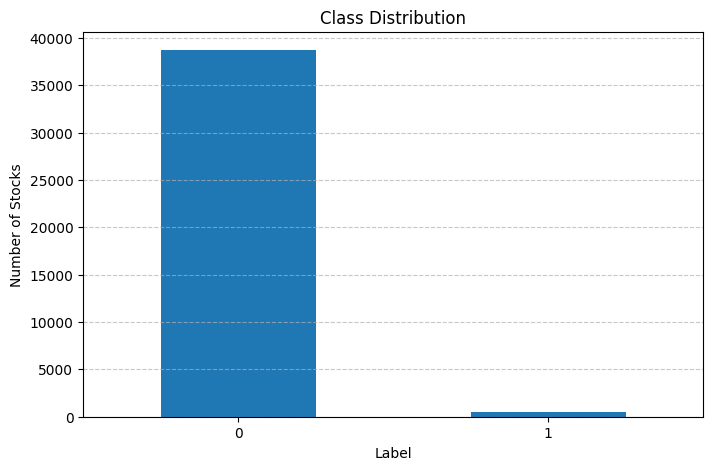

In [ ]:
#Display class distribution ----AP/HR edits
plt.figure(figsize=(8, 5))
y.value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Number of Stocks")
plt.xticks([0, 1], ["0", "1"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
#Create split ----AP
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

#print training and testing size
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

In [14]:
#Display class imbalance ratio
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Class imbalance ratio: {scale_pos_weight:.2f}")

Class imbalance ratio: 81.96


In [15]:
#XGB model ----AP
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [16]:
# Fit the model on the training data
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)
print("done")


Training XGBoost model...
done


#### Model Evaluation

In [17]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # P of class 1

print("Model Evaluation")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate and display additional metrics
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")

Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      7746
           1       0.08      0.62      0.14        94

    accuracy                           0.91      7840
   macro avg       0.54      0.76      0.55      7840
weighted avg       0.98      0.91      0.94      7840

ROC AUC Score: 0.8606
PR AUC Score: 0.1968


#### Confusion Matrix

<Figure size 800x600 with 0 Axes>

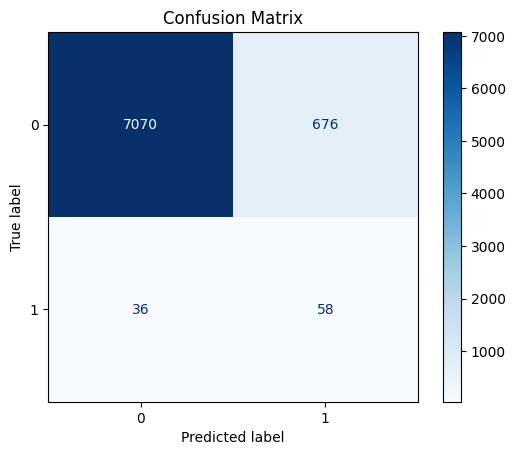

In [18]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [20]:
#Create feature importances and importance columns
importances = xgb_model.feature_importances_
features = X.columns

#Feature importance dataframe
feat_imp = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

<Figure size 1000x800 with 0 Axes>

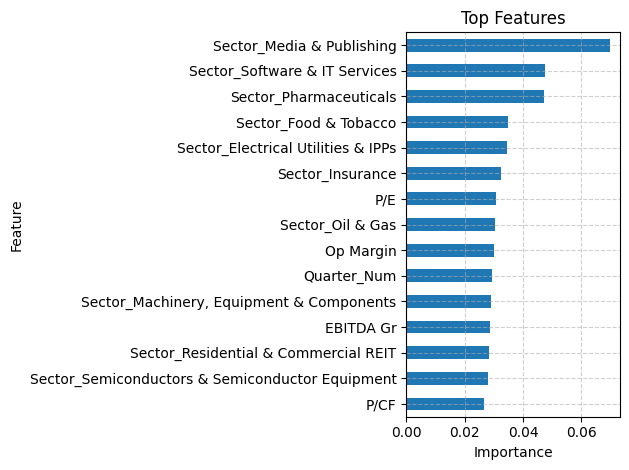

In [ ]:
#Plot feature importances
plt.figure(figsize=(10, 8))
top_n = min(15, len(feat_imp))
feat_imp.head(top_n).plot(kind="barh", x="Feature", y="Importance", legend=False)
plt.title("Top Features")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()